In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.font_manager as fm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

In [4]:
import warnings
warnings.filterwarnings('ignore')

-----------------------

# 1. 데이터 불러오기

In [5]:
df = pd.read_csv('./dataset/final_data/staple.csv', index_col="날짜")
df.head()

,레이블,WTI,환율,VIX,PBR,통화량,기준금리,소비자물가지수,수입금액지수,수출금액지수,...,미국경제성장률,OBV,ADI,EOM,MFI,MACD,ADX,RSI,ATR,ev_ebitda
날짜,,,,,,,,,,,,,,,,,,,,,
2013-06-18,up,98.44,1125.97,16.61,1.01,1884068.8,2.5,92.71,112.94,104.47,...,0.1,135346740.0,4244.43,7016.02,56.71,-5.30,25.86,55.38,18.50,0.097586
2013-06-19,up,98.24,1133.50,16.64,1.00,1884068.8,2.5,92.71,112.94,104.47,...,0.1,135338960.0,-1764.96,18892.06,53.89,-8.88,26.07,52.40,19.00,0.097586
2013-06-20,up,95.40,1129.60,20.49,0.99,1884068.8,2.5,92.71,112.94,104.47,...,0.1,135331560.0,-2622.35,28479.20,51.08,-12.32,26.56,50.38,18.95,0.097586
2013-06-21,up,93.69,1144.90,18.90,0.97,1884068.8,2.5,92.71,112.94,104.47,...,0.1,135323510.0,-95.79,17926.81,47.93,-15.25,27.82,39.10,18.33,0.100673
2013-06-24,up,95.18,1156.90,20.11,0.95,1884068.8,2.5,92.71,112.94,104.47,...,0.1,135310770.0,-9750.00,20685.90,42.60,-16.73,29.35,30.00,17.55,0.101386


------------------------

# 2. 데이터 전처리

## EDA

- 데이터 정보 확인

In [6]:
# df.info()

## 결측치 제거

- 결측치 제거(공휴일)
- PER 결측치 0으로 대체

In [7]:
# 코드 생략

- 결측치 제거 확인

In [8]:
# df.info()

## 기초통계량 확인

- 상대적으로 값이 큰(평균이 1000이 넘는) 피쳐는 로그 변환 실시가 필요함

In [9]:
# df.describe()

##  로그 변환

In [10]:
# # 통화량, 환율 로그 변환
# feature_to_log_transform = ['통화량', '환율']
# df[feature_to_log_transform] = np.log(df[feature_to_log_transform])

In [11]:
# df.describe()

## 정규성 확인 (for scaling method selection)
- 환율, PBR, 수입금액지수, 수출금액지수, 경제심리지수, 경지종합지수, 실업률, 고용률 : 정규성 o -> 최소 최대 스케일링 적용
- WTI, VIX, PER, 통화량, 기준금리, 소비자물가지수, 한국경제성장률, 미국경제성장률 : 정규성 x -> 표준화 스케일링 적용

In [12]:
# df.hist(figsize=(15,15))

## Test-Train-Split

In [13]:
encoder = LabelEncoder()
df['레이블']= encoder.fit_transform(df['레이블'])
df['레이블'].value_counts()

레이블
0    1053
2     717
1     596
Name: count, dtype: int64

In [14]:
X = df.drop('레이블',axis=1)
y = df[['레이블']]

In [15]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) 

In [16]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(y_train.value_counts())
print(y_test.value_counts())

1656
710
1656
710
레이블
0      737
2      502
1      417
Name: count, dtype: int64
레이블
0      316
2      215
1      179
Name: count, dtype: int64


In [17]:
# train_data = pd.concat([X_train,y_train], axis=1)
# test_data= pd.concat([X_test,y_test],axis=1 )

## 이상치

- Box Plot
    - train_data의 이상치 확인 (test_data는 과적합 방지 차원에서 건들지 않음)
    - 추가로 스케일링이 필요함을 확인할 수 있음

In [18]:
# plt.figure(figsize=(26, 13))
# X_train.boxplot()
# plt.title('Box Plot of Features')
# plt.ylabel('Values')
# plt.xlabel('Features')
# plt.show()

이상치는 존재하지만, 후보 피처 모두 실제 경제 상황을 나타내는 피처들이기 때문에 제거하지 않음. (맞는 논리?)

--------------------

# 3. 스케일링
- 분류 모델에서 스케일링이 필수적인 단계는 아니지만 성능을 조금이라도 높일 가능성과, 컴퓨팅 리소스 낭비 방지 차원에서 실시

In [19]:
# X_train = train_data.drop('레이블', axis=1)
# y_train = train_data[['레이블']]

# X_test = test_data.drop('레이블', axis=1)
# y_test = test_data[['레이블']]

- 스케일링
    - 환율, PBR, 수입금액지수, 수출금액지수, 경제심리지수, 경기종합지수, 실업률, 고용률 : 정규성 o 
    -> 표준화 스케일링 적용
    - WTI, VIX, PER, 통화량, 기준금리, 소비자물가지수, 한국경제성장률, 미국경제성장률 : 정규성 x 
    -> 최소 최대 스케일링 적용

In [20]:
# # 표준화 (StandardScaler)
# features_to_standardize = ['WTI', 'VIX', 'PER', '통화량', '기준금리', '소비자물가지수', '한국경제성장률', '미국경제성장률']
# scaler_standardize = StandardScaler()
# X_train[features_to_standardize] = scaler_standardize.fit_transform(X_train[features_to_standardize])
# X_test[features_to_standardize] = scaler_standardize.transform(X_test[features_to_standardize])

In [21]:
df.columns

Index(['레이블', 'WTI', '환율', 'VIX', 'PBR', '통화량', '기준금리', '소비자물가지수', '수입금액지수',
       '수출금액지수', '경제심리지수', '경기종합지수', '실업률', '고용률', '한국경제성장률', '미국경제성장률', 'OBV',
       'ADI', 'EOM', 'MFI', 'MACD', 'ADX', 'RSI', 'ATR', 'ev_ebitda'],
      dtype='object')

In [22]:
# 최소-최대 스케일링 (Min-Max Scaling)
features_to_minmax = ['환율', 'PBR', '수입금액지수', '수출금액지수', '경제심리지수', '경기종합지수', '실업률', '고용률','WTI', 'VIX', 'ev_ebitda', '통화량', '기준금리', '소비자물가지수', '한국경제성장률', '미국경제성장률', 'OBV', 'ADI', 'EOM', 'MFI', 'MACD', 'ADX', 'RSI', 'ATR']
scaler_standard = StandardScaler()
X_train[features_to_minmax] = scaler_standard.fit_transform(X_train[features_to_minmax])
X_test[features_to_minmax] = scaler_standard.transform(X_test[features_to_minmax])

In [23]:
X_train

,WTI,환율,VIX,PBR,통화량,기준금리,소비자물가지수,수입금액지수,수출금액지수,경제심리지수,...,미국경제성장률,OBV,ADI,EOM,MFI,MACD,ADX,RSI,ATR,ev_ebitda
날짜,,,,,,,,,,,,,,,,,,,,,
2014-03-13,1.507070,-1.076627,-0.256133,0.220607,-1.278297,1.251229,-1.056346,0.218983,0.133338,0.479351,...,-0.464016,0.645008,-0.050841,0.120330,-0.870634,-0.441950,-0.097042,-0.057747,-1.334166,-1.255878
2013-12-19,1.532797,-1.282341,-0.537525,0.136060,-1.339625,1.251229,-1.258096,0.068969,-0.215188,0.464355,...,0.089630,0.644864,-0.048516,-0.005506,-0.428171,0.073149,-1.241004,-0.356709,-1.017795,-1.229215
2016-04-20,-1.001112,-0.312250,-0.655791,1.784715,-0.706072,-0.123255,-0.746298,-1.376150,-1.338444,-0.285452,...,-0.111696,0.646800,-0.051453,-0.651219,0.403619,-0.895765,-0.218372,-1.763412,0.141592,0.393606
2016-08-16,-0.822827,-0.682483,-0.742791,1.150617,-0.576793,-0.466876,-0.723591,-1.080421,-1.423685,-0.015521,...,0.039299,0.674218,-1.313037,0.025828,1.718747,0.752708,-0.525739,0.851294,0.454105,1.171589
2018-12-13,-0.552014,-0.338240,0.346073,-0.286671,-0.020817,0.220366,-0.000655,0.007072,-0.079077,-0.075506,...,-0.162027,-0.411525,1.106510,0.024786,0.513980,0.306651,-1.342690,0.484275,0.085648,-0.378550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,-0.758283,0.305542,0.276745,1.235164,-0.651374,-0.466876,-0.738001,-1.284165,-1.010541,-0.165483,...,-0.111696,0.647062,-0.050777,0.679644,1.231322,-0.244909,0.495738,-0.968002,0.648944,0.785118
2019-12-16,-0.207630,0.294366,-0.810760,-0.709403,0.338713,-0.466876,0.158954,-0.044508,-0.152632,-1.140231,...,-0.061364,-1.355533,-0.263093,0.024899,-0.558968,0.428444,-0.739510,0.081405,-0.493081,0.526546
2018-07-05,0.366946,-0.462214,-0.426055,0.009241,-0.142595,-0.123255,-0.087556,0.101637,0.724525,0.254409,...,0.089630,-1.406839,-0.520099,0.024182,0.879804,0.647205,-0.455253,0.122725,-0.358044,0.129344


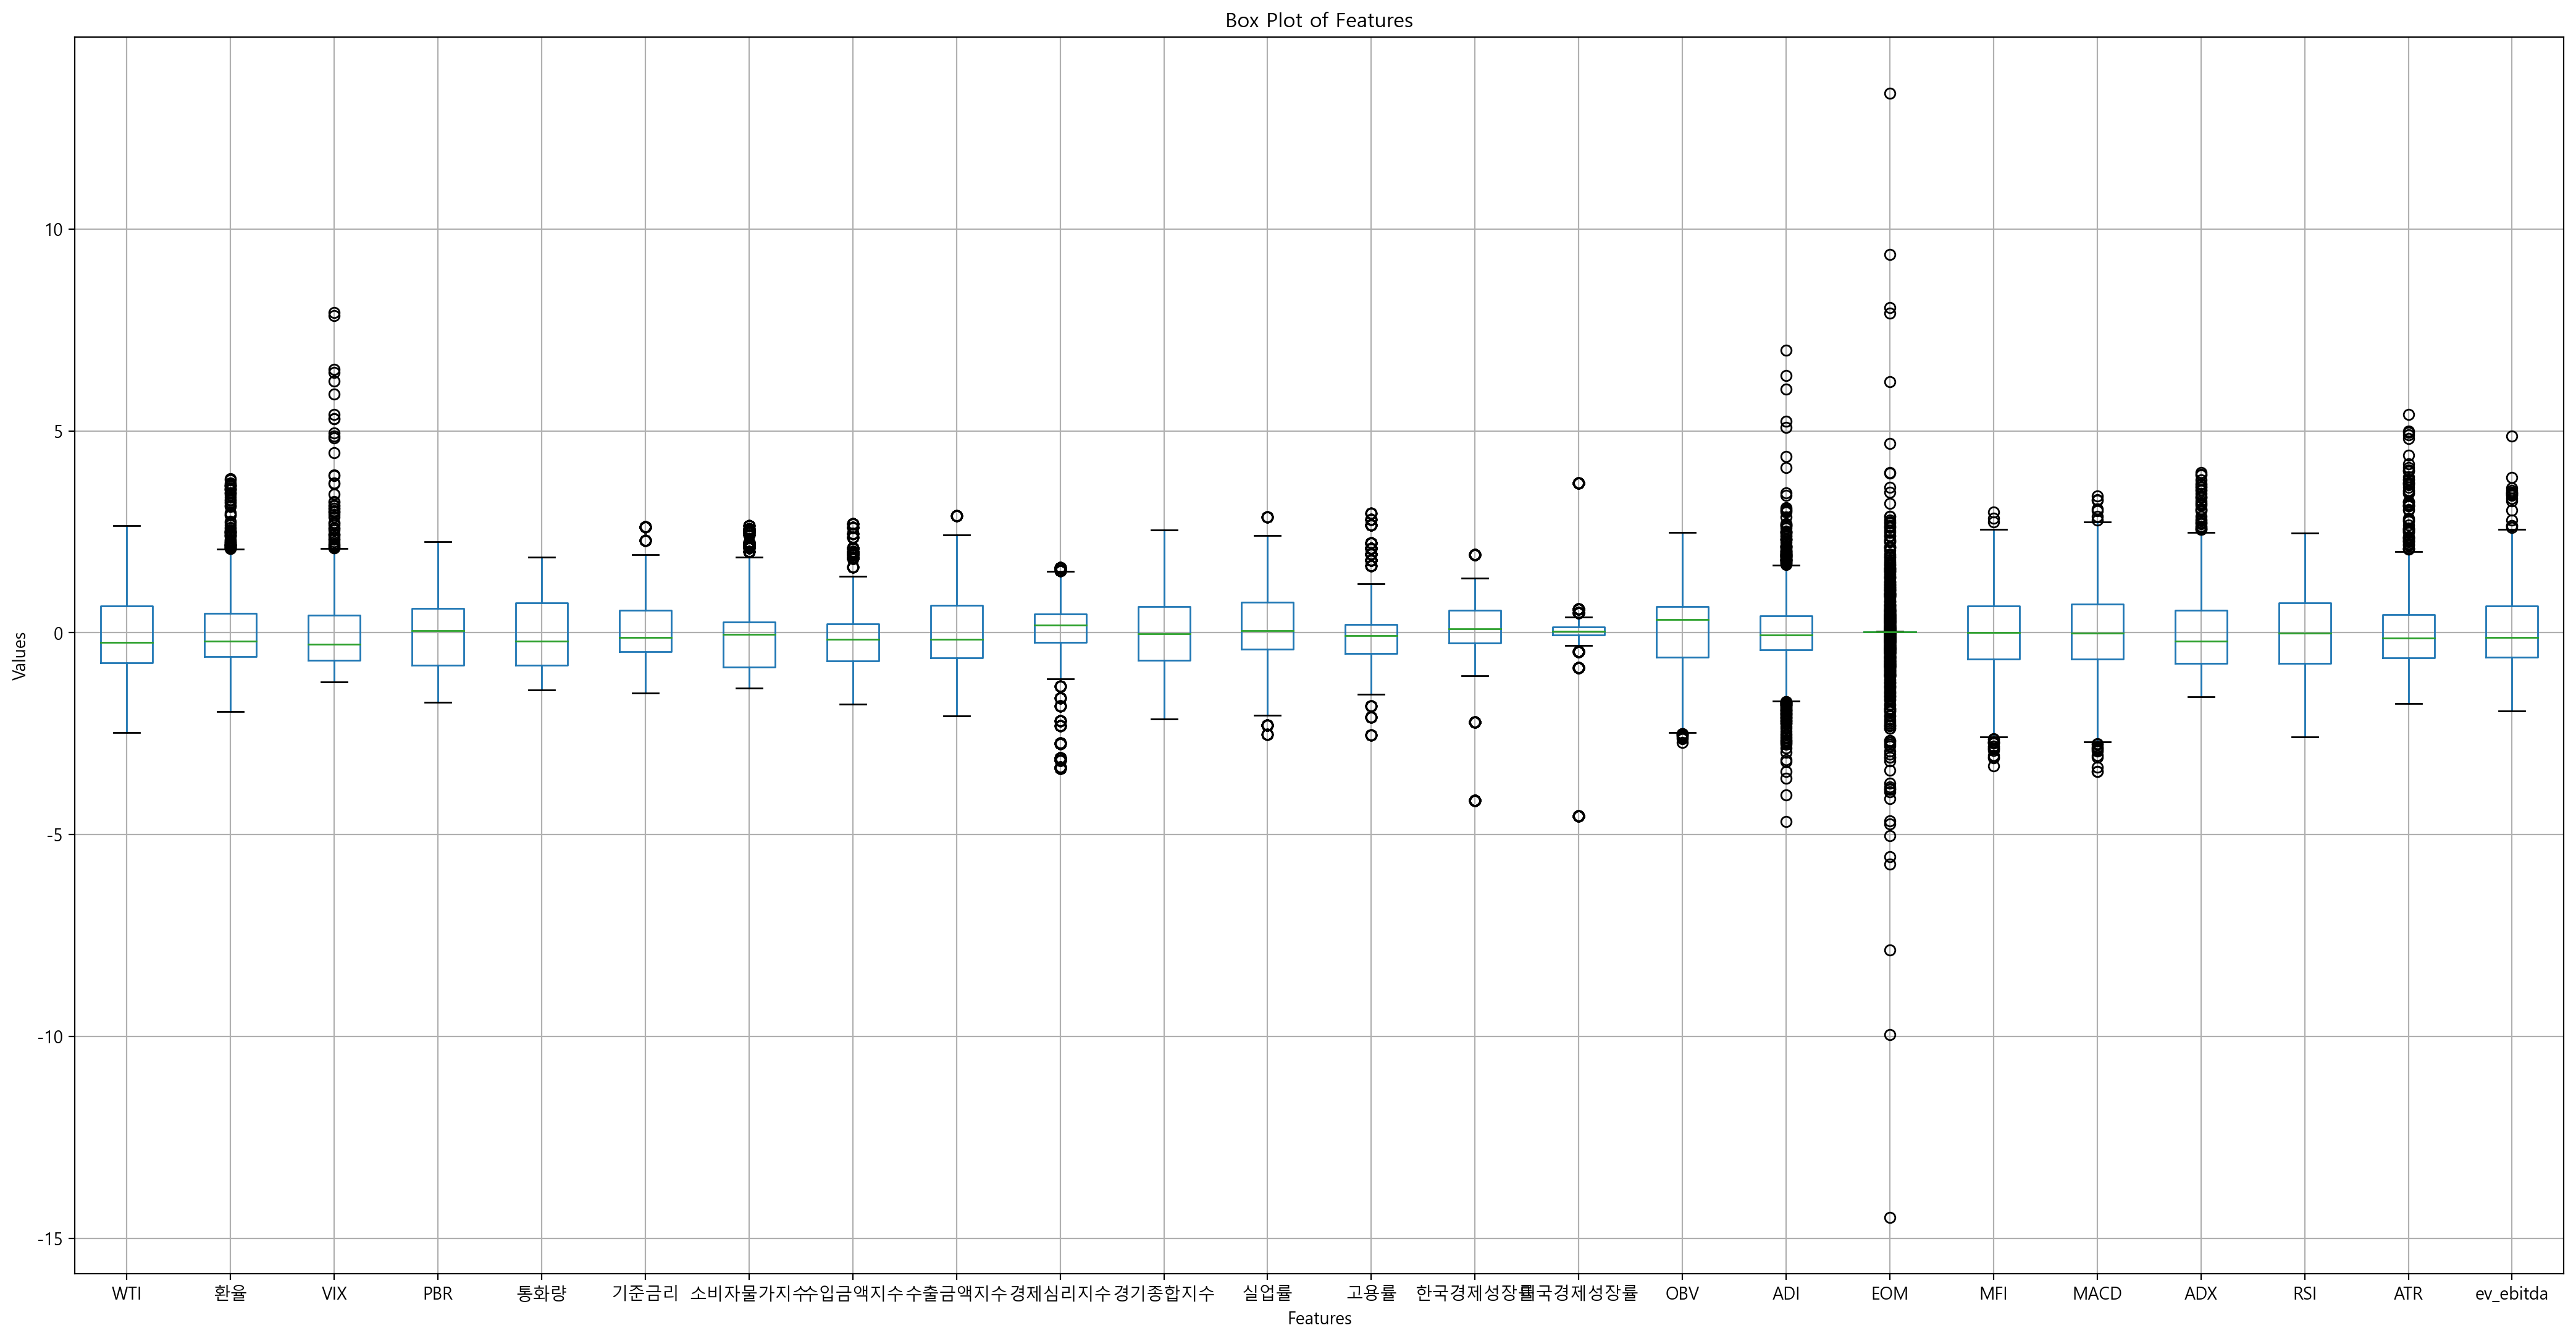

In [24]:
# 스케일링 결과 확인

plt.figure(figsize=(26, 13))
X_train.boxplot()
plt.title('Box Plot of Features')
plt.ylabel('Values')
plt.xlabel('Features')
plt.show()

## Q-Q plot

In [25]:
# import statsmodels.api as sm
# from scipy import stats

In [26]:
# # Q-Q plot 생성
# sm.qqplot(X_train, line='s')  # line='s'는 기준 선을 표시합니다.

# # 그래프 제목 및 레이블 설정
# plt.title('Q-Q Plot')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Sample Quantiles')

# # 그래프 표시
# plt.show()

In [27]:
# feature_names = [X_train.columns]

# # Loop through each feature
# for i, feature_name in enumerate(feature_names):
#     # Create a QQ plot for the current feature
#     sm.qqplot(X_train[feature_name], line='s')
#     plt.title(f'QQ Plot for {feature_name}')
#     plt.show()

---------------

## 4. 피처 셀렉션

- 먼저 feature_importance로 중요한 피처 순서 확인 -> 일별 데이터의 중요도가 높은 것으로 보아 후보 피처 선정의 한계점이 나타남
- 모델 기반 피처 선정 이후 이 값과 비교하여 타당성 확인

In [28]:
# X_train

In [29]:
# Feature_Importances

rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train, y_train)

rfc.feature_importances_

ftr_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
sorted_feature_importance = ftr_importances.sort_values(ascending=True)
data = sorted_feature_importance
importance = pd.DataFrame(data, columns=['feature importances'])
importance

,feature importances
ADI,0.018180
EOM,0.020107
한국경제성장률,0.022850
미국경제성장률,0.023432
실업률,0.028746
기준금리,0.029467
경기종합지수,0.030148
RSI,0.032851
MFI,0.032885
ADX,0.036145


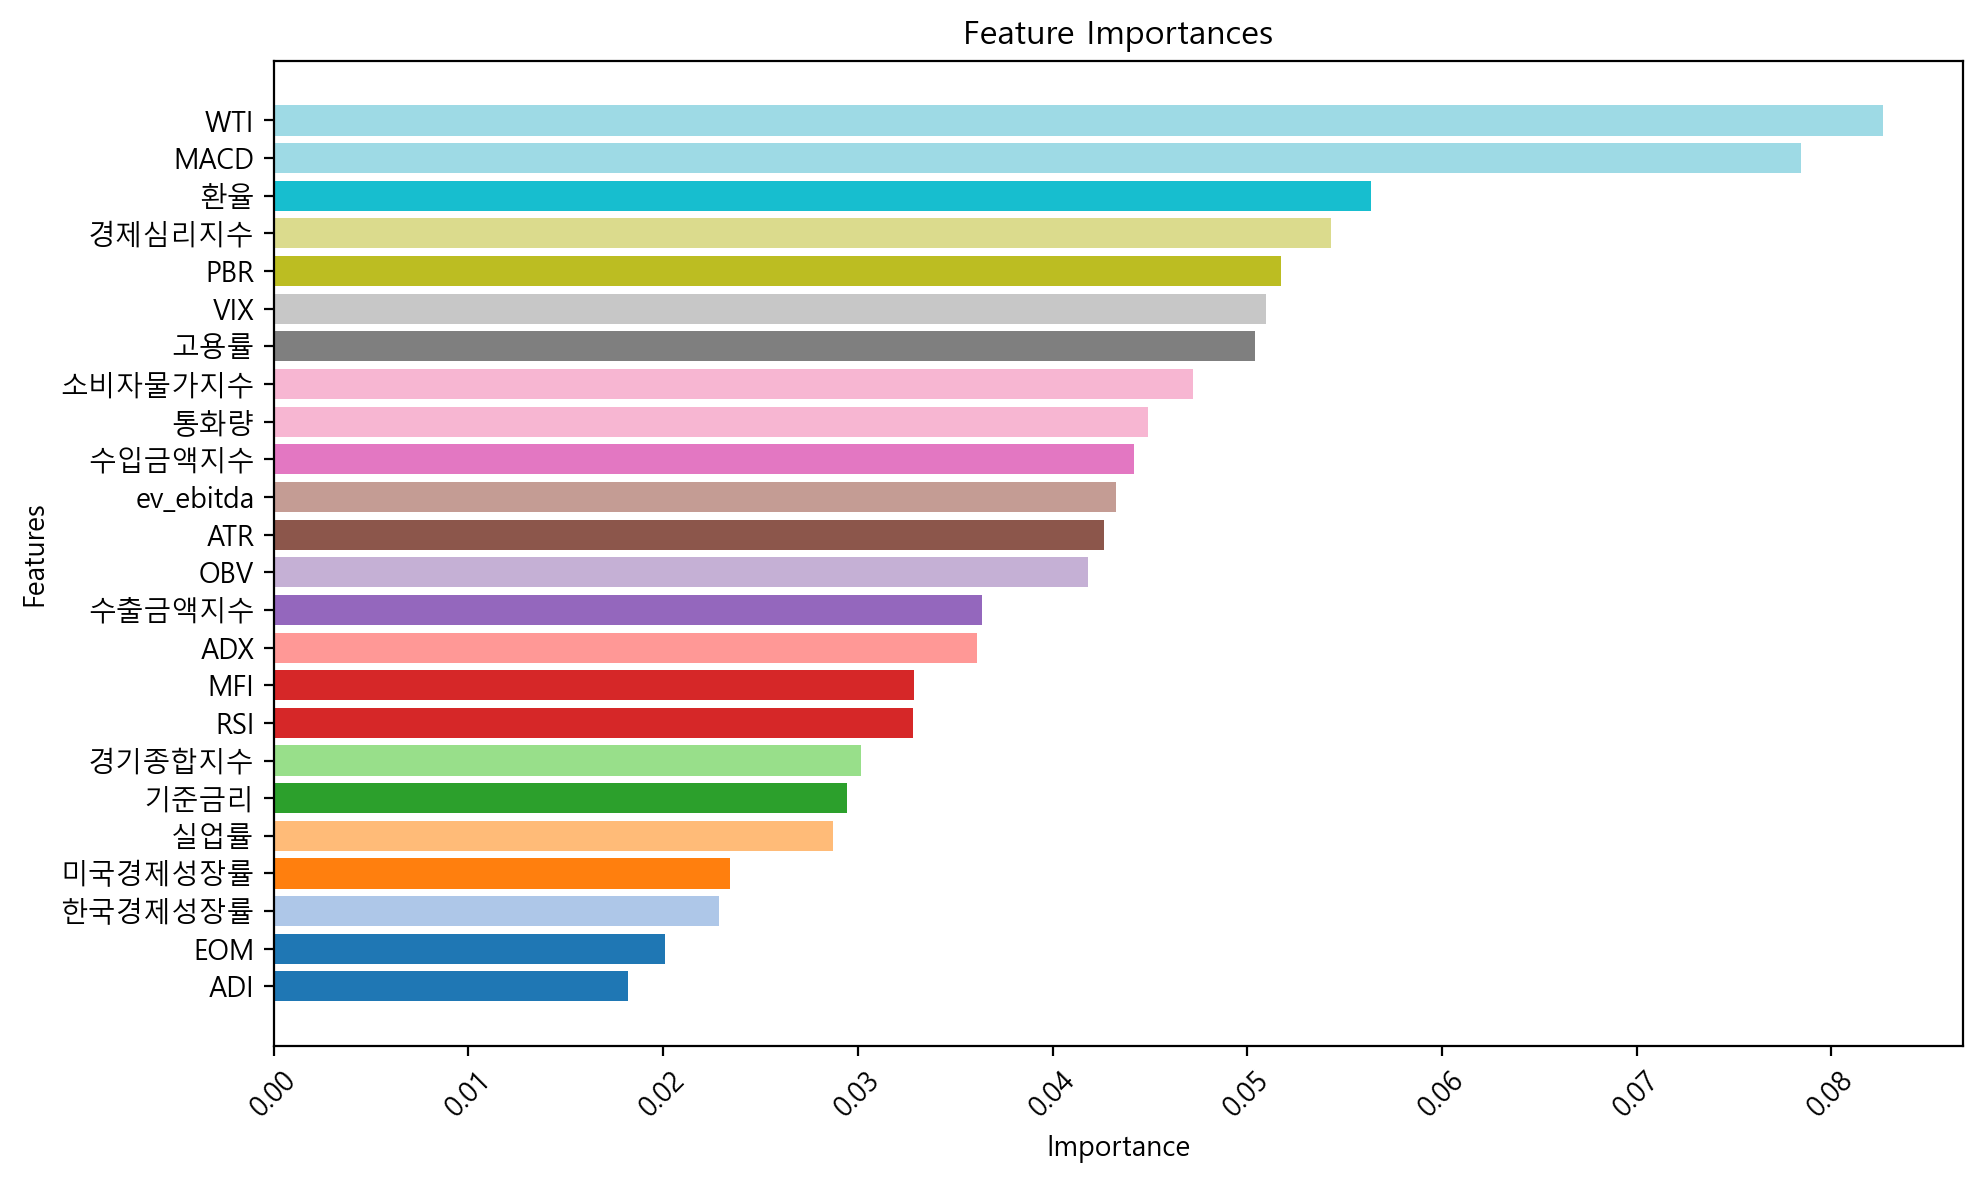

In [30]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(importance)))

plt.barh(importance.index, importance['feature importances'], color=colors)  # Changed to barh for horizontal bar chart
plt.ylabel('Features')  # Changed to 'Features' for Y-axis label
plt.xlabel('Importance')  # Changed to 'Importance' for X-axis label
plt.title('Feature Importances')

# Rotating x labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


## Feature 갯수 구하기 위한 Logit

### 질문 : logit.fit할 때 logit.fit(X, y) or logit.fit(X_train, y_train) 무엇이 맞나요?

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import numpy as np
lr_clf = LogisticRegression()


logit = SelectFromModel(LogisticRegression())
logit.fit(X_train, y_train)
logit_support = logit.get_support()
lr_feature = X_train.loc[:,logit_support].columns.tolist()

In [32]:
print(lr_feature)
print(len(lr_feature))

['WTI', 'PBR', '통화량', '소비자물가지수', '수입금액지수', 'OBV', 'MACD']
7


## 피처 선정

- Filter 방법은 분류 모델 특성 상 통계 기법의 중요도가 떨어지므로 생략

1. 전진선택법 by Wrapper
2. 후진선택법 by Wrapper
3. Stepwise선택법 by Wrapper
4. Lasso by embedded
5. Ridge by embedded
6. ElasticNet by embedded

In [33]:
# 1. 전진선택법 by Wrapper



selected_features = []
best_score = 0

while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_test[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_test)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nForward selected features:")
Forward = selected_features

Selected feature: MACD, Accuracy: 0.5746
Selected feature: WTI, Accuracy: 0.5986
Selected feature: 환율, Accuracy: 0.6225
Selected feature: 기준금리, Accuracy: 0.6310
Selected feature: PBR, Accuracy: 0.6423
Selected feature: OBV, Accuracy: 0.6563
Selected feature: 통화량, Accuracy: 0.6887
Selected feature: 소비자물가지수, Accuracy: 0.7056
Selected feature: ATR, Accuracy: 0.7197
Selected feature: 경제심리지수, Accuracy: 0.7239
Selected feature: RSI, Accuracy: 0.7282
Selected feature: 실업률, Accuracy: 0.7296
Selected feature: MFI, Accuracy: 0.7338
Selected feature: EOM, Accuracy: 0.7352

Forward selected features:


In [34]:
# 2. 후진선택법 by Wrapper



selected_features = X_train.columns.tolist()
best_score = 0

while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_test[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_test)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Backward = selected_features

Removed feature: 기준금리, Accuracy: 0.7380

Final selected features:


In [35]:
# 3. Stepwise선택법 by Wrapper



selected_features = []
best_score = 0

# Forward step
while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_test[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_test)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

# Backward step
while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_test[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_test)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Stepwise = selected_features

Selected feature: MACD, Accuracy: 0.5746
Selected feature: WTI, Accuracy: 0.5986
Selected feature: 환율, Accuracy: 0.6225
Selected feature: 기준금리, Accuracy: 0.6310
Selected feature: PBR, Accuracy: 0.6423
Selected feature: OBV, Accuracy: 0.6563
Selected feature: 통화량, Accuracy: 0.6887
Selected feature: 소비자물가지수, Accuracy: 0.7056
Selected feature: ATR, Accuracy: 0.7197
Selected feature: 경제심리지수, Accuracy: 0.7239
Selected feature: RSI, Accuracy: 0.7282
Selected feature: 실업률, Accuracy: 0.7296
Selected feature: MFI, Accuracy: 0.7338
Selected feature: EOM, Accuracy: 0.7352

Final selected features:


In [36]:
# 4. Lasso

lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : [0.001, 0.01, 0.1, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values(by=['rank_test_score'], ascending=True)
df[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.6963


In [97]:
lasso_best = LogisticRegression(C=0.03, penalty='l1', solver='liblinear').fit(X_train, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

,feature,coef
0,WTI,0.340696
1,환율,-0.258654
2,VIX,-0.137591
3,PBR,0.480364
7,수출금액지수,0.864887
10,한국경제성장률,-0.163372
11,OBV,-0.126343
14,MACD,0.844311
15,RSI,-0.149066
16,ATR,0.276408


In [98]:
# 라쏘에서 선택된 피처
lasso = df_lasso['feature'].values.tolist()
print('Lasso에서 선택된 피처 수 {0:1.0f}'.format(len(df_lasso)), '개')
lasso

Lasso에서 선택된 피처 수 10 개


['WTI', '환율', 'VIX', 'PBR', '수출금액지수', '한국경제성장률', 'OBV', 'MACD', 'RSI', 'ATR']

## 최종 피처 선정

In [99]:
list_Forward = list(Forward)
list_Backward = list(Backward)
list_Stepwise = list(Stepwise)
list_lasso = list(lasso)
list_col_all = X_train.columns

In [100]:
def func_Forward(x):
    if x in list_Forward:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in list_Backward:
        return 1
    else:
        return 0


def func_Stepwise(x):
    if x in list_Stepwise:
        return 1
    else:
        return 0
    
def func_lasso(x):
    if x in list_lasso:
        return 1
    else:
        return 0
    

In [101]:
# 2번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)


feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 17


,Feature,Forward,Backward,Stepwise,lasso,total
0,WTI,1,1,1,1,4
1,환율,1,1,1,1,4
2,VIX,0,1,0,1,2
3,PBR,1,1,1,1,4
4,통화량,1,1,1,0,3
5,기준금리,1,0,1,0,2
6,소비자물가지수,1,1,1,0,3
7,수출금액지수,0,1,0,1,2
8,경제심리지수,1,1,1,0,3
9,실업률,1,1,1,0,3


In [102]:
# 3번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)


feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=3]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 13


,Feature,Forward,Backward,Stepwise,lasso,total
0,WTI,1,1,1,1,4
1,환율,1,1,1,1,4
3,PBR,1,1,1,1,4
4,통화량,1,1,1,0,3
6,소비자물가지수,1,1,1,0,3
8,경제심리지수,1,1,1,0,3
9,실업률,1,1,1,0,3
11,OBV,1,1,1,1,4
12,EOM,1,1,1,0,3
13,MFI,1,1,1,0,3


In [103]:
# 4번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)

feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=4]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 7


,Feature,Forward,Backward,Stepwise,lasso,total
0,WTI,1,1,1,1,4
1,환율,1,1,1,1,4
3,PBR,1,1,1,1,4
11,OBV,1,1,1,1,4
14,MACD,1,1,1,1,4
15,RSI,1,1,1,1,4
16,ATR,1,1,1,1,4


In [44]:
# # 5번 선택된 Feature

# feature_counts = pd.DataFrame()
# feature_counts['Feature'] = list_col_all
# feature_counts['Forward'] = list_col_all.map(func_Forward)
# feature_counts['Backward'] = list_col_all.map(func_Backward)
# feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
# feature_counts['lasso'] = list_col_all.map(func_lasso)
# feature_counts['ridge'] = list_col_all.map(func_ridge)

# feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]+feature_counts["ridge"]
# feature_final = feature_counts[feature_counts["total"]>=5]
# list_feature_final = list(feature_final["Feature"])
# print("선택된 피쳐수 :", len(list_feature_final))
# feature_final

In [104]:
final_ftr = feature_final['Feature'].values

----------------------------------------

## 5. 다중공선성 확인 (생략 가능 단계)

- 분류 모델 특성 상 독립변수 간의 상관관계가 중요하지 않지만, <br> 이후 로지스틱회귀, SVM 모델도 사용할 것을 감안하여 다중공선성 확인

In [46]:
# X_train = X_train[lr_feature]
# X_test = X_test[lr_feature]

In [105]:
X_train = X_train[final_ftr]
X_test = X_test[final_ftr]

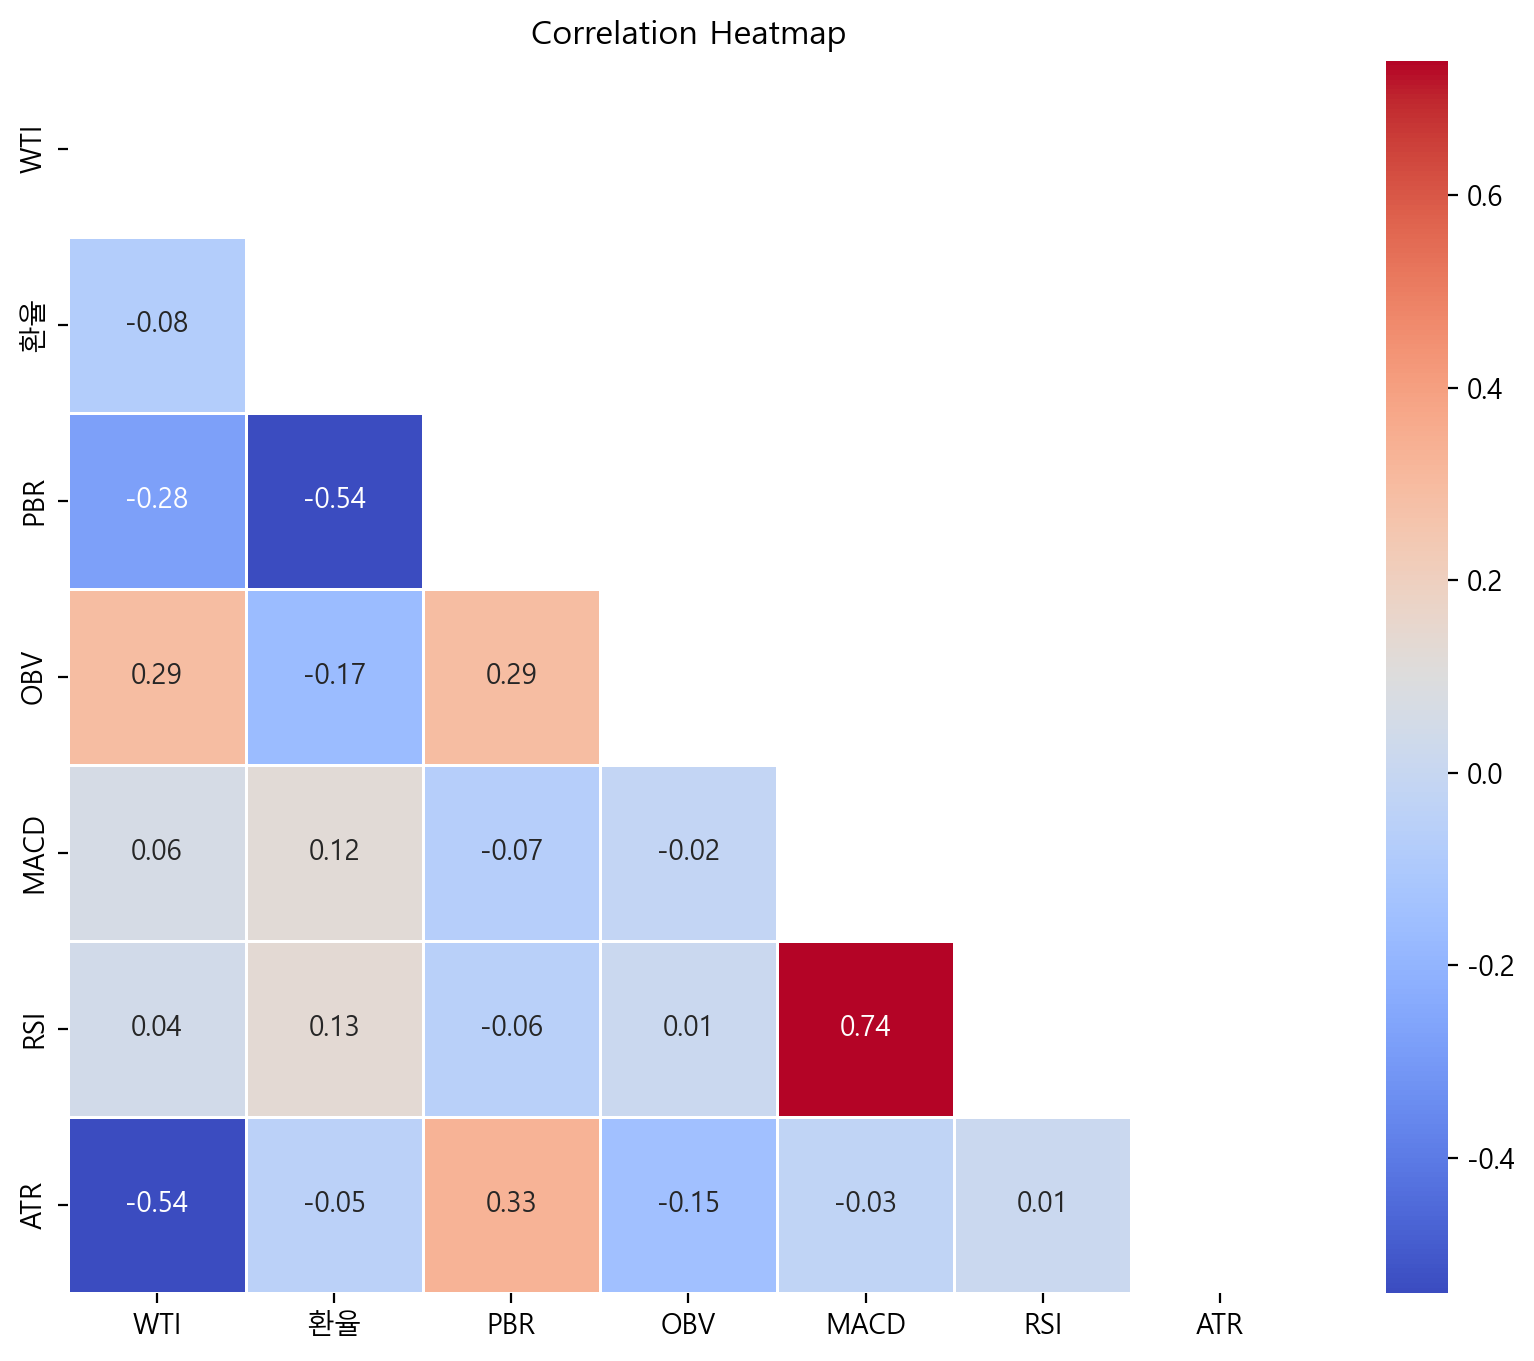

In [106]:
# 상관관계 행렬을 구합니다.
corr = X_train.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그립니다.
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', linewidths=.5, mask=mask)
plt.title('Correlation Heatmap')
plt.show()

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# extract effective features using variance inflation factor
vif = pd.DataFrame()

# variance_inflation_factor(X, i) : Xi를 x나머지로 회귀분석한 후 VIF값을 구한것. 즉 xi의 vif값. 즉 이값이 높을수록 종속성이 높다는 뜻

vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                     for i in range(X_train.shape[1])]
vif['Feature'] = X_train.columns
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,Feature
5,2.211562,RSI
4,2.210156,MACD
2,2.078501,PBR
0,1.722684,WTI
1,1.587677,환율
6,1.497985,ATR
3,1.352711,OBV


-----------------------

## 6. 모델링

In [108]:
def model_basic(X_train, y_train, X_test, y_test):
    models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        SVC(),
        RandomForestClassifier(),
        XGBClassifier(),
        LGBMClassifier()
    ]

    rdict={'model':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}

    for clf in models:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        results = (round(accuracy_score(y_test, pred), 2),
                    round(precision_score(y_test, pred, average='weighted'), 2),
                    round(recall_score(y_test, pred, average='weighted'), 2),
                    round(f1_score(y_test, pred, average='weighted'), 2))
        rdict['model'].append(clf.__class__.__name__)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [109]:
model_basic(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 1656, number of used features: 7
[LightGBM] [Info] Start training from score -0.809572
[LightGBM] [Info] Start training from score -1.379074
[LightGBM] [Info] Start training from score -1.193560


,model,accuracy,precision,recall,f1_score
0,LogisticRegression,0.64,0.60,0.64,0.60
1,DecisionTreeClassifier,0.81,0.81,0.81,0.81
2,SVC,0.80,0.80,0.80,0.80
3,RandomForestClassifier,0.89,0.89,0.89,0.89
4,XGBClassifier,0.88,0.88,0.88,0.88
5,LGBMClassifier,0.88,0.88,0.88,0.88


--------------

## 7. 교차 검증 & 하이퍼 파라미터 조정

------------------------

## 8. 투자 전략 구현 및 백테스팅

----------------